In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils

# %matplotlib qt

PATH = '../results/theorems/'
SEED = 0
SAVE = False
np.random.seed(SEED)

## Characterize graph models

In [2]:
def characterize_graph(G):
    N = G.N
    A = np.asarray(G.W.todense())
    min_degree =  np.min(np.sum(A, 1))
    D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
    A = D_root_inv.dot(A.dot(D_root_inv))
    L_A, V_A = utils.ordered_eig(A)
    
    # Print summary
    max_links = N*(N-1)/2
    print('N:', N, ':')
    print('\t- norm A:', np.linalg.norm(A))
    print('\t- Proportion of links:', G.Ne/max_links)
    print('\t- Min degree:', min_degree)
    print('\t- First eigenvalues:', L_A[:15])
    
    plt.figure()
    plt.imshow(A)
    plt.title('N: ' + str(N) + ' A norm')
    plt.figure()
    plt.stem(L_A, use_line_collection=True)
    plt.title('Eigenvalues of A')
    
def plot_expexted_A(Gs, n_samples):
    E_A = np.zeros((Gs['N'], Gs['N']))
    for i in range(n_samples):
        E_A += ds.create_graph(Gs, SEED).W.todense()
    E_A /= n_samples
    plt.figure()
    plt.imshow(E_A)
    plt.title('Expected A')

### SBM

N: 32 :
	- norm A: 2.8770024082615673
	- Proportion of links: 0.125
	- Min degree: 2
	- First eigenvalues: [ 1.          0.89173199  0.79725669  0.7621685  -0.76109628  0.7421589
  0.70906677 -0.6881596  -0.64854482 -0.57274071 -0.54935417 -0.53151529
  0.52101087 -0.48965619  0.47719373]
N: 128 :
	- norm A: 2.6603911862976872
	- Proportion of links: 0.1423474409448819
	- Min degree: 11
	- First eigenvalues: [ 1.          0.70834808  0.69967042  0.68094305  0.66508903  0.65190884
  0.63984955  0.62108541 -0.3294104  -0.32591098 -0.31207375 -0.30485675
 -0.29950204 -0.28703065 -0.28101741]
N: 512 :
	- norm A: 2.6511581909061586
	- Proportion of links: 0.1425513698630137
	- Min degree: 58
	- First eigenvalues: [ 1.          0.67592667  0.67306293  0.66269501  0.66155944  0.6478935
  0.64400334  0.64093537 -0.16433227 -0.15924859 -0.15830297 -0.15645514
 -0.15524026 -0.1543162  -0.15215969]

--- 0.07227993806203206 minutes ---


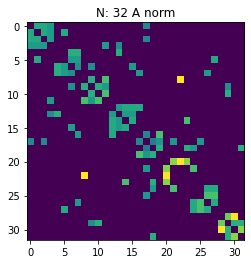

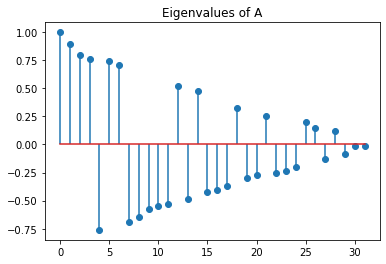

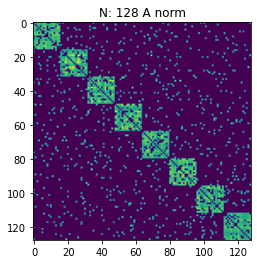

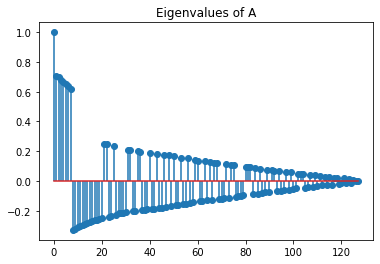

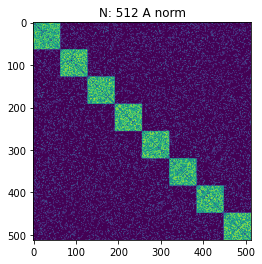

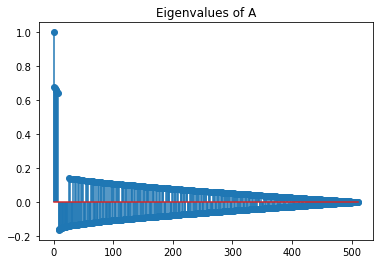

In [3]:
Gs = {'type': ds.SBM, 'k': 8, 'type_z': ds.CONT, 'p':0.8, 'q': 0.05}
sizes = [32, 128, 512]
start_time = time.time()
for N in sizes:
    Gs['N'] = N
    G = ds.create_graph(Gs, SEED)
    characterize_graph(G)

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Caveman

N: 32 :
	- norm A: 3.2317865716108862
	- Proportion of links: 0.0967741935483871
	- Min degree: 2.0
	- First eigenvalues: [ 1.          0.96935699  0.96935699  0.88958156  0.88958156  0.79866586
  0.79866586  0.75631585 -0.72420131 -0.69763709 -0.69763709 -0.63053229
 -0.63053229 -0.55870909 -0.55870909]
N: 128 :
	- norm A: 2.921132635300197
	- Proportion of links: 0.11811023622047244
	- Min degree: 14.0
	- First eigenvalues: [ 1.          0.99783483  0.99783483  0.99257284  0.99257284  0.98726049
  0.98726049  0.98504495 -0.15784502 -0.15602033 -0.15602033 -0.15161587
 -0.15161587 -0.14721464 -0.14721464]
N: 512 :
	- norm A: 2.850786402213621
	- Proportion of links: 0.1232876712328767
	- Min degree: 62.0
	- First eigenvalues: [ 1.          0.99985913  0.99985913  0.99951889  0.99951889  0.99917843
  0.99917843  0.99903734 -0.03814336 -0.03802355 -0.03802355 -0.03773466
 -0.03773466 -0.03744624 -0.03744624]

--- 0.06202431122461955 minutes ---


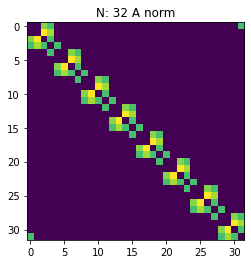

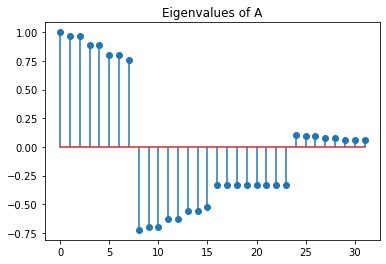

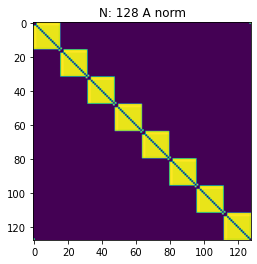

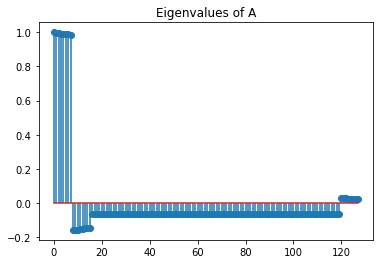

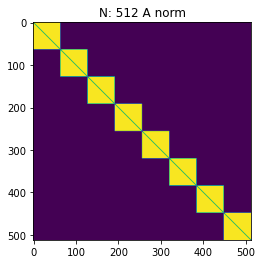

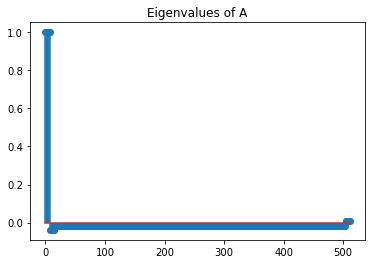

In [4]:
Gs = {'type': ds.CAVE, 'l': 8}
sizes = [32, 128, 512]
start_time = time.time()
for N in sizes:
    Gs['N'] = N
    G = ds.create_graph(Gs, SEED)
    characterize_graph(G)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Regular - Constant proportion of links

N: 32 :
	- norm A: 2.1380899352993947
	- Proportion of links: 0.22580645161290322
	- Min degree: 7.0
	- First eigenvalues: [ 1.         -0.64998525  0.59265895 -0.5308007  -0.50895833  0.50590777
 -0.47304232  0.4562947  -0.43803306  0.42441182  0.40619149 -0.38378839
  0.36875475 -0.3300154   0.30680635]
N: 128 :
	- norm A: 2.0320020320030476
	- Proportion of links: 0.2440944881889764
	- Min degree: 31.0
	- First eigenvalues: [ 1.         -0.30361914 -0.28871165  0.28536115 -0.28210077 -0.27839377
  0.27671414 -0.27365727  0.27178358  0.2652552  -0.26265953 -0.25977612
  0.257255   -0.25398271  0.25357959]
N: 512 :
	- norm A: 2.007858576442103
	- Proportion of links: 0.24853228962818003
	- Min degree: 127.0
	- First eigenvalues: [ 1.         -0.15307623  0.15059039 -0.15032668 -0.14831518  0.1480797
 -0.14760448  0.14698723 -0.14609579  0.14504097 -0.14411069  0.14391977
 -0.14371824 -0.14334357 -0.14274951]

--- 0.07443980773289999 minutes ---


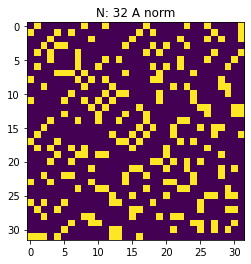

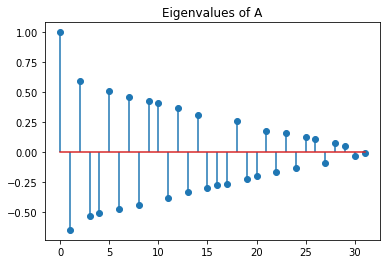

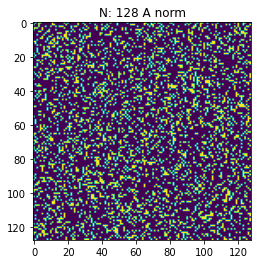

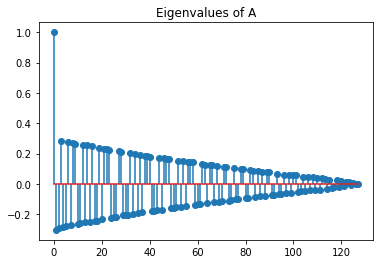

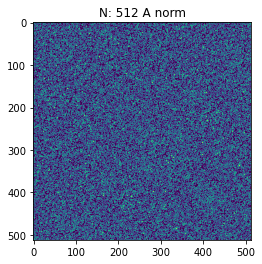

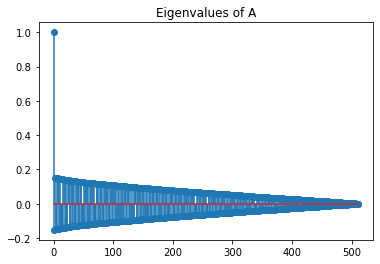

In [6]:
Gs = {'type': ds.REG, 'd': 0.25}
sizes = [32, 128, 512]
start_time = time.time()
for N in sizes:
    Gs['N'] = N
    G = ds.create_graph(Gs, SEED)
    characterize_graph(G)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Small World - Constant proportion of links

N: 32 :
	- norm A: 2.3148980181569816
	- Proportion of links: 0.1935483870967742
	- Min degree: 4.0
	- First eigenvalues: [ 1.          0.85502539  0.728757    0.63648748  0.58396917 -0.54777365
 -0.49289694 -0.45450518 -0.44064838 -0.42434785  0.3958829  -0.37611681
  0.35426878 -0.35240563 -0.32428678]
N: 128 :
	- norm A: 2.0655312695285697
	- Proportion of links: 0.23622047244094488
	- Min degree: 23.0
	- First eigenvalues: [ 1.          0.67162495  0.64802079  0.48728745  0.45118895 -0.2893685
  0.27185253 -0.26386286  0.25455491 -0.25388604 -0.24750247 -0.23080006
 -0.22424276 -0.2194047  -0.21726923]
N: 516 :
	- norm A: 2.007814635873113
	- Proportion of links: 0.24854368932038834
	- Min degree: 113.0
	- First eigenvalues: [ 1.          0.61826934  0.61331663  0.43914549  0.43814411  0.21827324
  0.21442837 -0.1766463  -0.16851839 -0.15344383 -0.14830947 -0.12966982
 -0.12509078  0.12213717 -0.11808084]

--- 0.07169038454691569 minutes ---


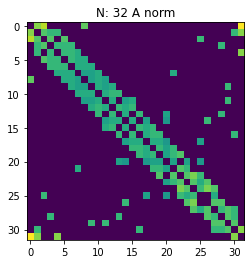

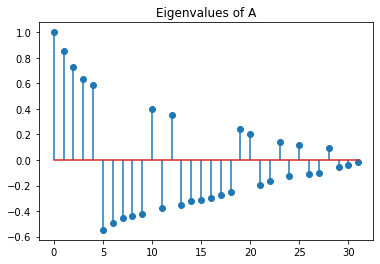

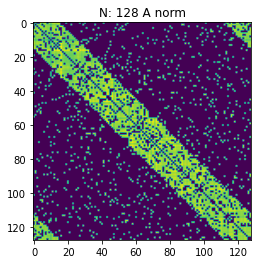

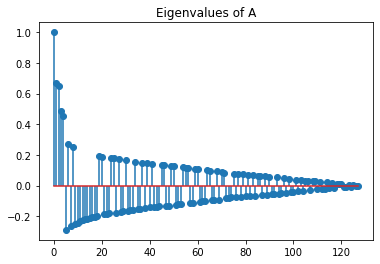

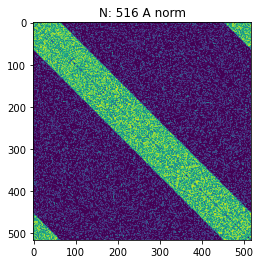

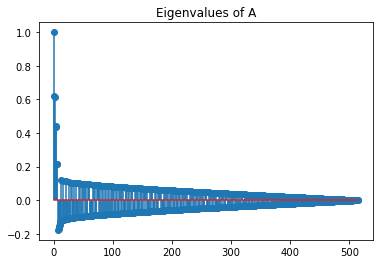

In [8]:
Gs = {'type': ds.SW, 'k': 0.25, 'p': 0.25}
sizes = [32, 128, 516]
start_time = time.time()
for N in sizes:
    Gs['N'] = N
    G = ds.create_graph(Gs, SEED)
    characterize_graph(G)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

### Power Law Cluster

N: 32 :
	- norm A: 1.8143915588683632
	- Proportion of links: 0.30443548387096775
	- Min degree: 5.0
	- First eigenvalues: [ 1.         -0.51554291  0.47652265 -0.46979475  0.44723433 -0.37758249
  0.37040661 -0.35833169 -0.34820983  0.30938814 -0.30801426 -0.30490539
  0.29937812 -0.26737097  0.2431369 ]
N: 128 :
	- norm A: 1.7834090541759557
	- Proportion of links: 0.3068405511811024
	- Min degree: 20.0
	- First eigenvalues: [ 1.         -0.30945884 -0.29010722 -0.25015963  0.23841284  0.23702905
 -0.23502819 -0.23132025 -0.22868381  0.22337209  0.22047457  0.21773083
  0.21519151 -0.21175431 -0.21116017]
N: 516 :
	- norm A: 1.7789919275722412
	- Proportion of links: 0.3080981410401144
	- Min degree: 98.0
	- First eigenvalues: [ 1.         -0.27219029 -0.2280821  -0.17064801 -0.13108372  0.12766607
 -0.12474946  0.12417687  0.12369192 -0.12221061  0.12136136 -0.12030611
  0.1201056   0.11989672 -0.11863639]

--- 0.07899837493896485 minutes ---


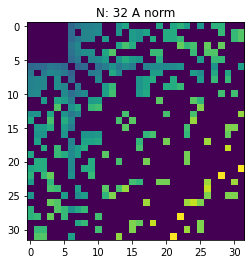

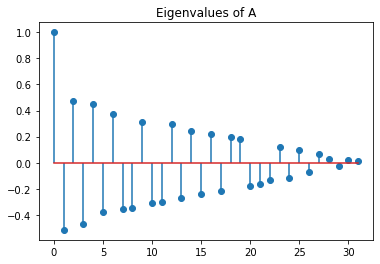

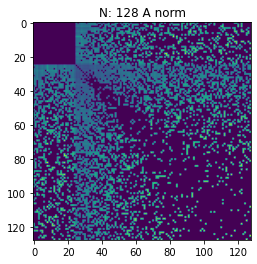

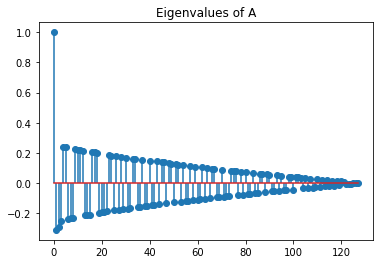

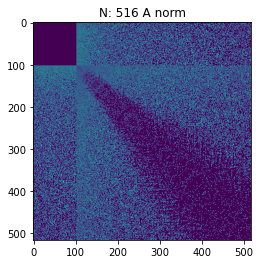

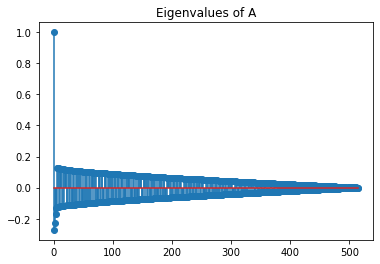

In [9]:
Gs = {'type': ds.PLC, 'm': 0.2, 'p': 0.2}
sizes = [32, 128, 516]
start_time = time.time()
for N in sizes:
    Gs['N'] = N
    G = ds.create_graph(Gs, SEED)
    characterize_graph(G)
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

## Check eigenvector similarity

In [10]:
np.random.seed(SEED)

# Graph parameters
GRAPHS = [{'Gs': {'type': ds.SBM, 'k': 8, 'type_z': ds.CONT, 'p':0.8, 'q': 0.05}, 'K': 8, 'leg': 'SBM'},
          {'Gs': {'type': ds.CAVE, 'l': 8}, 'K': 8, 'leg': 'CAVE'},
          {'Gs': {'type': ds.REG, 'd': 0.4}, 'K': 1, 'leg': 'REG'},
          {'Gs': {'type': ds.SW, 'k': 0.25, 'p': 0.25}, 'K': 5, 'leg': 'SW'},
          {'Gs': {'type': ds.PLC, 'm': 0.1, 'p': 0.3}, 'K': 1, 'leg': 'PLC'},
         ]

# Filter parameters
L = 3
hs = np.random.rand(L)
hs /= np.sum(hs)
h_params = {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': False}

n_graphs = 50
KK = [None]
NN = [50, 100, 500, 1000, 2000]

In [11]:
err_eigvec = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))
mean_err_eigvec = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))
err_eigvec_norm = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))
eig_ratio_Ep = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))

eig_ratio_A = np.zeros((len(NN), len(GRAPHS), n_graphs))
eig_ratio_E = np.zeros((len(NN), len(GRAPHS), n_graphs))
start_time = time.time()
for i, graph in enumerate(GRAPHS):
    print(graph['leg'] + ':', end=' ')
    for j, N in enumerate(NN):
        graph['Gs']['N'] = N
        for g in range(n_graphs):
            G = ds.create_graph(graph['Gs'], SEED)
            A = np.asarray(G.W.todense())
            D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
            A = D_root_inv.dot(A.dot(D_root_inv))
            L_A, V_A = utils.ordered_eig(A)

            # Calculate Exp Jacobian
            H = utils.create_filter(A, h_params)
            H2 = H.dot(H.T)
            H_norm = H/np.linalg.norm(H, axis=0)
            H2_norm = H_norm.T.dot(H_norm)
            H2_norm[H2_norm>1] = 1
            Z = 1-np.arccos(H2_norm)/np.pi
            E_JJ = 0.5*Z*(H2)

            L_E_JJ, V_E_JJ = utils.ordered_eig(E_JJ)
            V_E_JJ = utils.choose_eig_sign(V_E_JJ, V_A)

            for k in range(len(KK)):
                K = KK[k]
                if KK[k] is None:
                    K = graph['K']
                if K < 1:
                    K = int(KK[k]*N)

                err_eigvec[k, j, i, g] = np.linalg.norm(V_A[:, :K]-V_E_JJ[:, :K],'fro')
                mean_err_eigvec[k, j, i, g] = err_eigvec[k, j, i, g]/K
                err_eigvec_norm[k, j, i, g] = err_eigvec[k, j, i, g]/np.linalg.norm(V_A[:, :K],'fro')
                eig_ratio_Ep[k, j, i, g] = L_E_JJ[K-1]/L_E_JJ[K]

            eig_ratio_A[j, i, g] = (L_A[0]/L_A[-1])**2
            eig_ratio_E[j, i, g] = (L_E_JJ[0]/L_E_JJ[-1])**2
        
        print(N, end=' ')
    print()
    
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))


SBM: 50 100 500 

In [7]:
# np.save('../results/theorems/eig_sim.npy',err_eigvec)
# np.save('../results/theorems/eig_sim_mean.npy',mean_err_eigvec)
# np.save('../results/theorems/eig_sim_norm.npy',err_eigvec_norm)

## Plot eigenvector ratio

In [29]:
#legend_K = ['(' gs['leg'] + '-' + str(gs['K']) for i,gs in enumerate(GRAPHS)]
#legend_noK = [gs['leg'] for gs in GRAPHS]

legend_K = []
legend_noK = []
for i, gs in enumerate(GRAPHS):
    legend_K.append('{}, K={}'.format(gs['leg'], gs['K']))
    legend_noK.append('{}'.format(gs['leg']))

legend = legend_K
med_err_eigvec = np.median(err_eigvec, axis=3)
med_mean_err_eigvec = np.median(mean_err_eigvec, axis=3)
med_err_eigvec_norm = np.median(err_eigvec_norm, axis=3)
med_eig_ratio_Ep = np.median(eig_ratio_Ep, axis=3)
for k in range(len(KK)):
    if k == 1:
        legend = legend_noK
    
    f2 = plt.figure()
    plt.loglog(NN, med_mean_err_eigvec[k], linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Number of nodes',fontsize=18)
    plt.ylabel('Eigenvector error',fontsize=18)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim([1e-6, 1])
    plt.xticks(fontsize=18, ticks=NN, labels=NN)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    
    f3 = plt.figure()
    plt.loglog(NN, med_err_eigvec_norm[k], linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Number of nodes',fontsize=18)
    plt.ylabel('Norm Eigenvector error',fontsize=18)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim([1e-6, 1])
    plt.xticks(fontsize=18, ticks=NN, labels=NN)
    plt.yticks(fontsize=18)
    plt.tight_layout()

    if SAVE:
        f2.savefig('{}mean_eig_sim_k_{}.eps'.format(PATH, k))
        f3.savefig('{}ratio_kth_eigval_k_{}.eps'.format(PATH, k))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [28]:
#legend_K = ['(' gs['leg'] + '-' + str(gs['K']) for i,gs in enumerate(GRAPHS)]
#legend_noK = [gs['leg'] for gs in GRAPHS]

legend_K = []
legend_noK = []
for i, gs in enumerate(GRAPHS):
    legend_K.append('({}). {}, K={}'.format(i+1, gs['leg'], gs['K']))
    legend_noK.append('{}'.format(i+1, gs['leg']))

legend = legend_K
med_err_eigvec = np.median(err_eigvec, axis=3)
mean_mean_err_eigvec = np.mean(mean_err_eigvec, axis=3)
med_err_eigvec_norm = np.median(err_eigvec_norm, axis=3)
med_eig_ratio_Ep = np.median(eig_ratio_Ep, axis=3)
for k in range(len(KK)):
    if k == 1:
        legend = legend_noK
    
    f1 = plt.figure()
    plt.loglog(NN, med_err_eigvec[k])
    plt.grid(True, which='both')
    plt.title('Eigenvectors Similarity (K: {})'.format(KK[k]))
    plt.xlabel('Number of nodes')
    plt.legend(legend)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.tight_layout()
    
    
    f2 = plt.figure()
    plt.loglog(NN, med_mean_err_eigvec[k])
    plt.grid(True, which='both')
    plt.title('Mean Eig Similarity (K: {})'.format(KK[k]))
    plt.xlabel('Number of nodes')
    plt.legend(legend)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.tight_layout()
    
    f3 = plt.figure()
    plt.loglog(NN, med_err_eigvec_norm[k])
    plt.grid(True, which='both')
    plt.title('Norm Eig Similarity (K: {})'.format(KK[k]))
    plt.xlabel('Number of nodes')
    plt.legend(legend)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.tight_layout()

    if SAVE:
        f1.savefig('{}eig_sim__loglog_k_{}.eps'.format(PATH, k))
        f2.savefig('{}mean_eig_sim_k_{}.eps'.format(PATH, k))
        f3.savefig('{}ratio_kth_eigval_k_{}.eps'.format(PATH, k))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
#f1.savefig('{}eig_sim_k_{}.png'.format(PATH, k))
print('{}eig_sim_k_{}.png'.format(PATH, k))

../results/imgs/theorems/eig_sim_k_0.png


In [20]:
plt.show()